In [1]:
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

e:\repos\SURP-2024\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_excel('GS3.xlsx')
df.sample(3)

,Year,Question
96,2019,Define the concept of carrying capacity of an ...
163,2015,How can the Digital India program help farmers...
63,2020,What are the challenges and opportunities of f...


In [4]:
questions = df['Question'].values.tolist()
questions[:3]

['Faster economic growth requires increased share of the manufacturing sector in GDP, particularly of MSMEs. Comment on the present policies of the Government in this regard.',
 'What is the status of digitalization in the Indian economy? Examine the problems faced in this regard and suggest improvements.',
 'How does e-Technology help farmers in production and marketing of agricultural produce? Explain it.']

In [5]:
#PIPELINE OF BERTMODEL
# 1. EMBEDDING - BY DEFAULT USES all-MiniLM-L6-v2 SENTENCE TRANSFORMER
# 2.  

In [6]:
#USING DIFFERENT WORD EMBEDDINGS
#USING SENTENCE TRANSFORMER
"""
    The all-mpnet-base-v2 model provides superior accuracy and a deeper understanding of the context and nuances in the text.
    Given the manageable size of your dataset (200-300 questions), 
    the additional computational resources required by this model are justified by the improved performance and precision.  
    Recommendation : huggingface transformer model sentence-transformers/stsb-roberta-large is best for this with best accuracy as far as i could find,
    but requires so much computation my little laptop cannot handle.
    even this model all-mpnet-base-v2 is heavy but i can manage it. like it takes 4-5 minutes to run the model.  
"""
sentence_model = SentenceTransformer('all-mpnet-base-v2')

In [7]:
#USING FINETUNING 
from bertopic.representation import KeyBERTInspired
from bertopic.representation import MaximalMarginalRelevance
from bertopic.representation import PartOfSpeech

representation = [PartOfSpeech("en_core_web_sm"),MaximalMarginalRelevance(diversity=0.2),KeyBERTInspired(top_n_words=30)]

# model = BERTopic(embedding_model=sentence_model,representation_model=representation,verbose=True,calculate_probabilities=True, nr_topics=30, n_gram_range=(1, 3), min_topic_size=3)



In [8]:
#UPDATING C-TF-IDF
from bertopic.vectorizers import ClassTfidfTransformer
ctfidf_model = ClassTfidfTransformer(bm25_weighting=True,reduce_frequent_words=True)
model = BERTopic(embedding_model=sentence_model,representation_model=representation,ctfidf_model=ctfidf_model,verbose=True,calculate_probabilities=True, nr_topics=8, n_gram_range=(1, 3), min_topic_size=3)

In [9]:
topics, probs = model.fit_transform(questions)

2024-07-14 08:00:08,935 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:10<00:00,  1.33s/it]
2024-07-14 08:00:19,608 - BERTopic - Embedding - Completed ✓
2024-07-14 08:00:19,608 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-14 08:00:31,299 - BERTopic - Dimensionality - Completed ✓
2024-07-14 08:00:31,299 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-14 08:00:31,333 - BERTopic - Cluster - Completed ✓
2024-07-14 08:00:31,333 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-07-14 08:00:48,114 - BERTopic - Representation - Completed ✓
2024-07-14 08:00:48,115 - BERTopic - Topic reduction - Reducing number of topics
2024-07-14 08:00:57,917 - BERTopic - Topic reduction - Reduced number of topics from 15 to 8


In [10]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 3))
model.update_topics(questions,vectorizer_model=vectorizer_model)

In [11]:
model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,23,-1_economy_sector_intensive_exports,"[economy, sector, intensive, exports, india, t...",[The China Pakistan Economic Corridor (CPEC) i...
1,0,58,0_india_energy_water_discuss,"[india, energy, water, discuss, programme, spa...",[Describe the key points of the revised Global...
2,1,51,1_security_discuss_india_cyber,"[security, discuss, india, cyber, threat, chal...",[India’s proximity to two of the world’s bigge...
3,2,39,2_food_india_farmers_land,"[food, india, farmers, land, agricultural, agr...","[How do subsidies affect the cropping pattern,..."
4,3,29,3_growth_inclusive_india_inclusive growth,"[growth, inclusive, india, inclusive growth, g...",[Normally countries shift from agriculture to ...
5,4,13,4_disaster_disaster management_management_vuln...,"[disaster, disaster management, management, vu...",[The frequency of urban floods due to high int...
6,5,9,5_tax_budget_gst_goods,"[tax, budget, gst, goods, goods services, good...",[Discuss the rationale for introducing the Goo...
7,6,6,6_available_discuss_patents_patent,"[available, discuss, patents, patent, knowledg...",[Can overuse and free availability of antibiot...


In [12]:
model.visualize_documents(questions)

In [13]:
model.visualize_topics()

In [14]:
model.visualize_barchart()

In [15]:
topics_label = model.get_topic_info()['Name'].tolist()
for i in range(len(topics_label)):
    topics_label[i] = ' '.join(topics_label[i].split('_')[1:])
topics_label

['discuss intensive exports india',
 'india growth food farmers',
 'security discuss india cyber',
 'india energy disaster discuss',
 'tax budget gst goods',
 'space mission achieved india',
 'available discuss patents patent',
 'technology therapy cell therapy nanotechnology']

In [17]:
import numpy as np
question_index = 129
topic_probabilities = probs[question_index]
significant_probs = topic_probabilities[topic_probabilities > 0.05]
significant_topics = np.arange(len(topic_probabilities))[topic_probabilities > 0.05]
others = np.sum(topic_probabilities[topic_probabilities <= 0.05])

# Labels for the pie chart
labels = [topics_label[i+1] for i in significant_topics] + ["Others"]

# Probabilities to plot
probs_to_plot = np.append(significant_probs, others)

In [18]:
probs[question_index]

array([0.15051369, 0.6040635 , 0.11533686, 0.02717205, 0.03292977,
       0.03804567, 0.03193846])

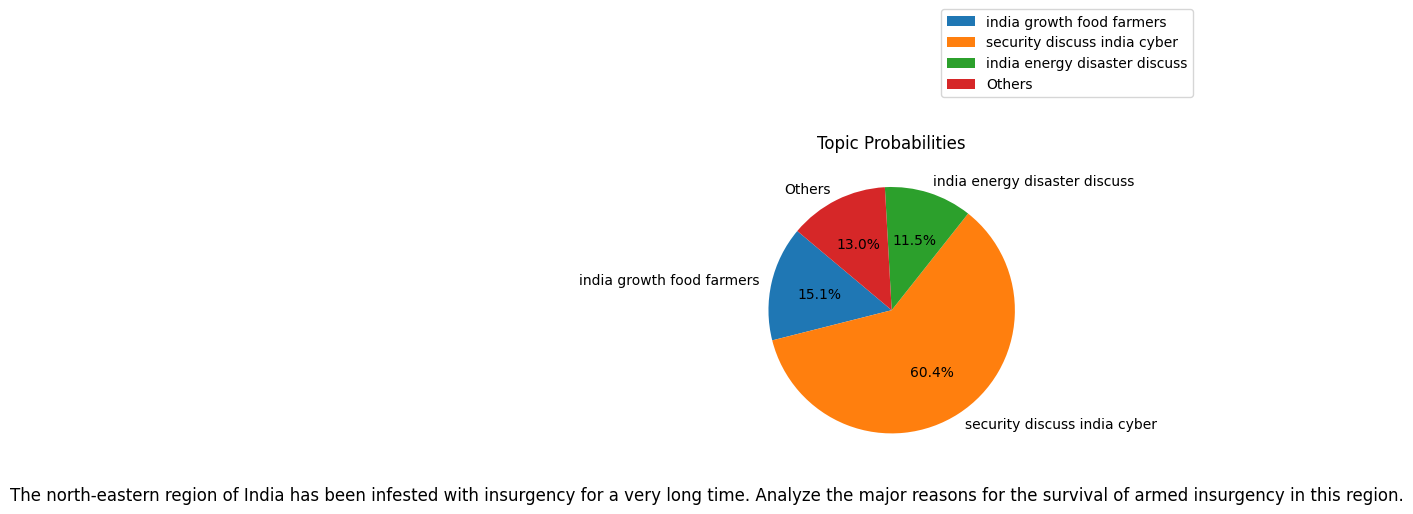

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4))
plt.pie(probs_to_plot, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Topic Probabilities')
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.5))
plt.text(-1.5, -1.5, questions[question_index], fontsize=12, ha="center", va="center")
plt.show()

In [21]:
df['Topic_Number'] = topics
df.sample(5)

,Year,Question,Topic_Number
115,2018,With growing energy needs should India keep on...,2
61,2020,Define potential GDP and explain its determina...,0
205,2013,India needs to strengthen measures to promote ...,0
215,2013,What do you understand by Umpire Decision Revi...,1
157,2016,"""Terrorism is emerging as a competitive indust...",1


In [22]:

df['Topic'] = df['Topic_Number'].apply(lambda x: " ".join(model.get_topic_info(topic=x)['Name'].iloc[0].split('_')[1:]))

# Display the first few rows of the DataFrame
df.head()

,Year,Question,Topic_Number,Topic
0,2023,Faster economic growth requires increased shar...,0,india growth food farmers
1,2023,What is the status of digitalization in the In...,-1,discuss intensive exports india
2,2023,How does e-Technology help farmers in producti...,0,india growth food farmers
3,2023,State the objectives and measures of land refo...,0,india growth food farmers
4,2023,Introduce the concept of Artificial Intelligen...,1,security discuss india cyber


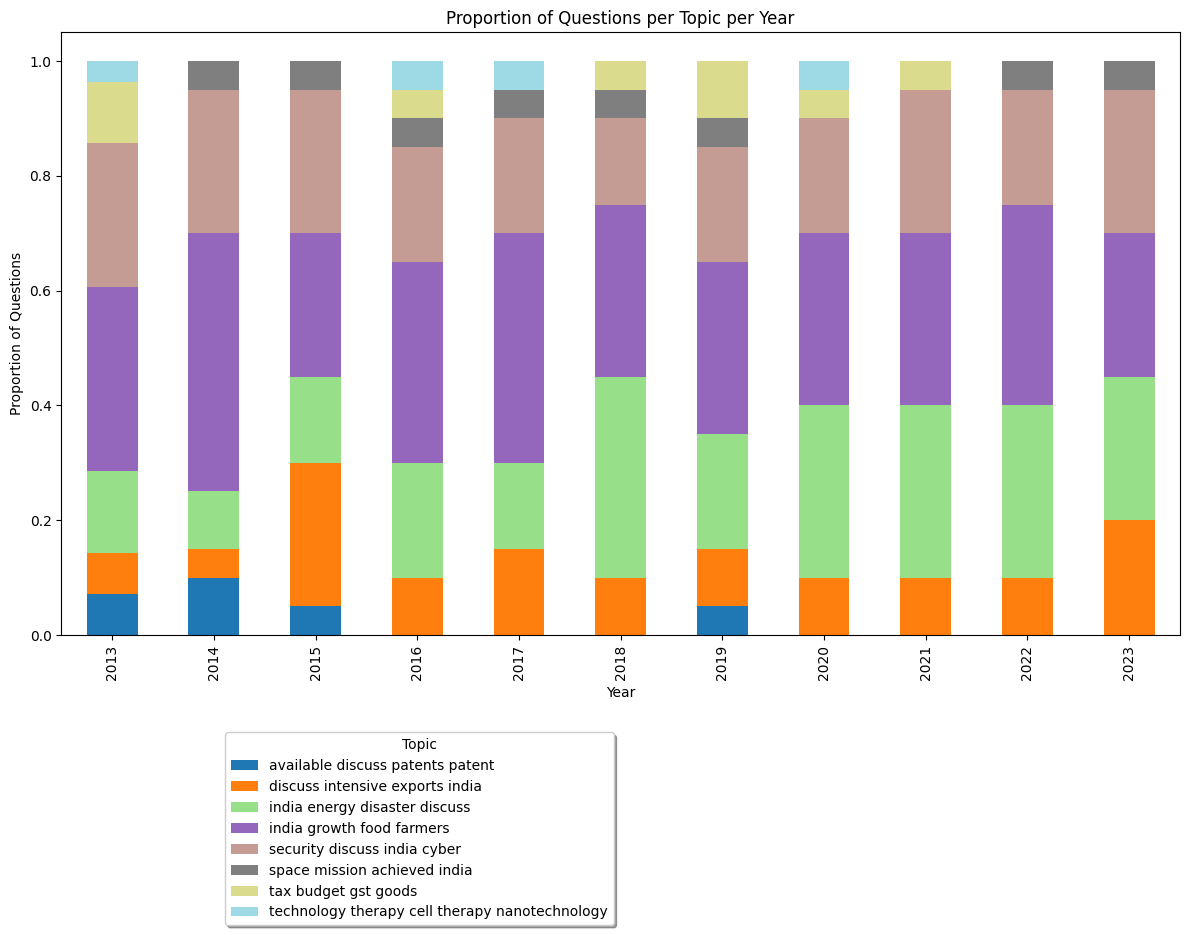

In [23]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming df is your DataFrame and it now includes a 'Topic' column after categorization

# Step 2: Count questions per topic per year
topic_year_counts = df.groupby(['Year', 'Topic']).size().reset_index(name='Count')

# Calculate the total number of questions per year
total_questions_per_year = topic_year_counts.groupby('Year')['Count'].transform('sum')

# Calculate the proportion of questions per topic per year
topic_year_counts['Proportion'] = topic_year_counts['Count'] / total_questions_per_year

# Step 3: Prepare data for plotting (normalized)
pivot_table = topic_year_counts.pivot(index='Year', columns='Topic', values='Proportion')

# Generate a list of colors from a colormap
num_topics = len(pivot_table.columns)
colors = plt.get_cmap('tab20', num_topics)

# Step 4: Plot the normalized data with different colors for each topic
pivot_table.plot(kind='bar', stacked=True, figsize=(12, 8), color=[colors(i) for i in range(num_topics)])

# Step 5: Customize the plot
plt.xlabel('Year')
plt.ylabel('Proportion of Questions')
plt.title('Proportion of Questions per Topic per Year')
plt.legend(title='Topic', loc='best', bbox_to_anchor=(0.5, -0.15), ncol=1, fancybox=True, shadow=True)
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
embeddings = model._extract_embeddings(questions)
tsne = TSNE(n_components=2,random_state=42)
reduced = tsne.fit_transform(embeddings)

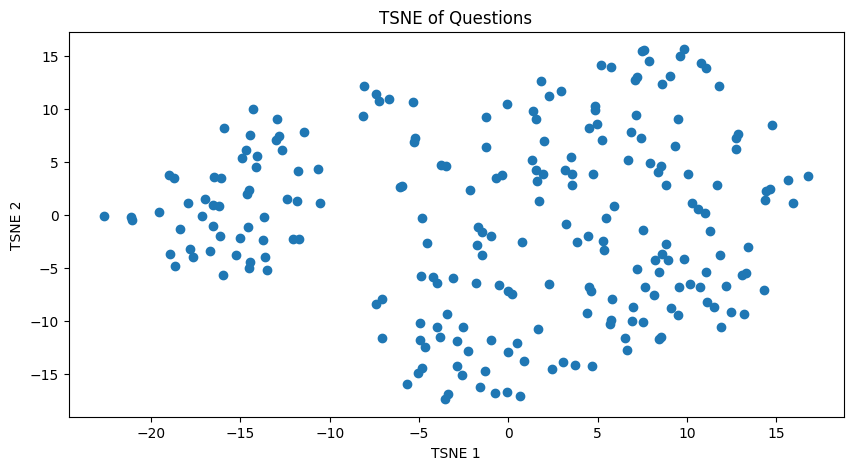

In [25]:
plt.figure(figsize=(10,5))
plt.scatter(reduced[:,0], reduced[:,1])
plt.title("TSNE of Questions")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.show()

In [19]:
model.save("GS3_model")

2024-07-14 08:19:06,004 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [15]:
from bertopic.representation import ZeroShotClassification
candidate_labels = ['Technology','Economic Development','Biodiversity','Environmnet','Security','Disaster Management']
representation_model = ZeroShotClassification(candidate_labels, model="facebook/bart-large-mnli")



In [20]:
topic_model = BERTopic(embedding_model=sentence_model,representation_model=representation_model,ctfidf_model=ctfidf_model,verbose=True,calculate_probabilities=True, nr_topics=6, n_gram_range=(1, 3), min_topic_size=3)

In [21]:
topics, probs = topic_model.fit_transform(questions)

2024-07-14 08:19:38,972 - BERTopic - Embedding - Transforming documents to embeddings.
Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches: 100%|██████████| 8/8 [00:14<00:00,  1.87s/it]
2024-07-14 08:19:53,981 - BERTopic - Embedding - Completed ✓
2024-07-14 08:19:53,982 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-14 08:20:00,810 - BERTopic - Dimensionality - Completed ✓
2024-07-14 08:20:00,810 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-14 08:20:00,867 - BERTopic - Cluster - Completed ✓
2024-07-14 08:20:00,870 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-07-14 08:21:08,893 - BERTopic - Representation - Completed ✓
2024-07-14 08:21:08,893 - BERTopic - Topic reduction - Reducing number of topics
2024-07-14 08:21:30,538 - BERTopic - Topic reduction - Reduced number of topics from 16 to 6


In [22]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,26,-1_of_water_the_exports,"[of, water, the, exports, intensive, economy, ...",[The China Pakistan Economic Corridor (CPEC) i...
1,0,87,0_in_the_and_how,"[in, the, and, how, of, what, india, in india,...","[Launched on 25th December, 2021, James Webb S..."
2,1,65,1_Security___,"[Security, , , , , , , , , ]","[On December 2004, tsumani brought havoc on 14..."
3,2,41,2_growth_in_inclusive_the,"[growth, in, inclusive, the, inclusive growth,...",[With a consideration towards the strategy of ...
4,3,6,3_available_patents_database_traditional knowl...,"[available, patents, database, traditional kno...",[Can overuse and free availability of antibiot...
5,4,3,4_is oil_is oil pollution_oil_oil pollution,"[is oil, is oil pollution, oil, oil pollution,...",[What is oil pollution? What are its impacts o...


In [23]:
representation.append(representation_model)

In [36]:
topic_model = BERTopic(embedding_model=sentence_model,representation_model=representation,ctfidf_model=ctfidf_model,verbose=True,calculate_probabilities=True, nr_topics='auto', n_gram_range=(1, 3), min_topic_size=5)

In [32]:
topics, probs = topic_model.fit_transform(questions)

2024-07-14 08:45:02,226 - BERTopic - Embedding - Transforming documents to embeddings.
Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches: 100%|██████████| 8/8 [00:15<00:00,  1.92s/it]
2024-07-14 08:45:17,630 - BERTopic - Embedding - Completed ✓
2024-07-14 08:45:17,631 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-14 08:45:24,891 - BERTopic - Dimensionality - Completed ✓
2024-07-14 08:45:24,895 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-14 08:45:24,956 - BERTopic - Cluster - Completed ✓
2024-07-14 08:45:24,957 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-07-14 08:47:23,738 - BERTopic - Representation - Completed ✓
2024-07-14 08:47:23,795 - BERTopic - Topic reduction - Reducing number of topics
2024-07-14 08:48:34,822 - BERTopic - Topic reduction - Reduced number of topics from 15 to 10


In [33]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,25,-1_the impact of_impact of_food security_discu...,"[the impact of, impact of, food security, disc...","[Each year a large amount of plant material, c..."
1,0,76,0_the indian economy_indian economy_of inclusi...,"[the indian economy, indian economy, of inclus...",[Capitalism has guided the world economy to un...
2,1,51,1_Security___,"[Security, , , , , , , , , ]",[India’s proximity to two of the world’s bigge...
3,2,27,2_on climate change_renewable energy_hydroelec...,"[on climate change, renewable energy, hydroele...",[Should the pursuit of carbon credits and clea...
4,3,14,3_Disaster Management___,"[Disaster Management, , , , , , , , , ]",[The frequency of urban floods due to high int...
5,4,11,4_Technology___,"[Technology, , , , , , , , , ]",[Stem cell therapy is gaining popularity in In...
6,5,9,5_the gst introduced_impacted the gst_the gst ...,"[the gst introduced, impacted the gst, the gst...",[Discuss the rationale for introducing the Goo...
7,6,6,6_indian patent law_patenting by pharmaceutica...,"[indian patent law, patenting by pharmaceutica...",[Can overuse and free availability of antibiot...
8,7,5,7_of biotechnology_of biotechnology in_biotech...,"[of biotechnology, of biotechnology in, biotec...",[Why is there so much activity in the field of...
9,8,4,8_india wetlands_india wetlands of_of wetland ...,"[india wetlands, india wetlands of, of wetland...",[What is wetland? Explain the Ramsar concept o...


In [34]:
topic_model.visualize_documents(questions)

In [35]:
topic_model.visualize_topics()

In [38]:
model = BERTopic.load('GS3_model')

TypeError: 'int' object is not callable